In [2]:
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


# Basics

Before heading into linear regression and the generalized linear model, we introduce some basic notation.

## Data organization

*Structured* data is organized as one or multiple tables. Each row of a table represents an *observation*, each column $X$ a *variable* and each cell a *value*. A value in column $X$ can be viewed as a realization of the *random variable* $X$. 

Examples of *unstructured* data are images, text, audio or video data. We will deal with structured data only.

Throughout this lecture, we will consider the following two data sets:

- `diamonds`: Diamonds prices along with the four "C"-variables: Carat, Color, Cut, and Clarity. Each observation/row represents a diamond.

- `dataCar`: Insurance claim data on vehicle insurance policies from 2004-2005. Some variables like `gender` describe the policy holder, others like `veh_age` the vehicle and some variables carry information on eventual claims. Each row represents a policy.

### Example: diamonds

Let us have look at the first six observations of the diamonds data set.

In [3]:
from plotnine.data import diamonds

diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


**Comment:** The data set is neatly structured. It seems to be sorted by price.

## Data types

We distinguish variables by their data type.

- **numerical:** The values of a numerical variable are numbers. Taking sums, means and differences makes sense. Examples: house prices, insurance claim frequencies, blood pressure.
- **categorical:** The values of a categorical variable are categories, e.g. house types, claim types or colors. Depending on whether categories follow a natural order, we talk of *ordered* or *unordered* categoricals. Categories can be encoded by numbers. That does not make the variable numeric though.
- **binary:** A binary variable just takes two values (male/female, yes/no, ...) that can be represented by 1/0. It counts as both numeric and categorical.

Data types are important in determining suitable analysis methods.

### Example: diamonds

In the `diamonds` data set, we will consider the numeric variables `price` and `carat` and the following *ordered* categoricals:

- `color` with ordered categories D < E < F < G < H < I < J,
- `cut` with ordered categories Fair < Good < Very Good < Premium < Ideal, and
- `clarity` with ordered categories I1 < SI2 < SI1 < VS2 < VS1 < VVS2 < VVS1 < IF.

There are no unordered categoricals or binary variables in this data set.

## Descriptive analysis

Statistical modeling always starts with a descriptive analysis of the data. This typically involves a numeric and/or graphical summary of each variable and the most relevant variable pairs, e.g. 

- for numeric variables: mean, standard deviation, quartiles, minimum and maximum; boxplots, mean plots,
- for categorical variables: absolute or relative counts; bar plots,
- for binary variables: like a categorical variable or simply the mean,
- for important pairs of numeric variables: correlations; scatter plots,
- the important pairs of categorical variables: frequency tables; mosaic plots,
- for important pairs of categorical *and* numerical variables: stratified means; mean plots, boxplots.

The more time we invest in the descriptive analysis, the more we learn about the data. Additionally, we might 

- identify data errors and problematic outliers (uncommonly small or large values), 
- find join keys to combine multiple data sources, 
- detect variables with high number of missing values,
- detect variables with no or almost no information (e.g. all values the same),
- **learn how the data is structured** (what *is* a row? do we deal with time series? are rows grouped to clusters etc.),
- ...

During or after the descriptive analysis, we usually do the *data preprocessing* for the modeling task.

### Example: diamonds

Let us summarize the diamonds data set.

#### Univariate description

,price,carat
count,53940.000000,53940.000000
mean,3932.799722,0.797940
std,3989.439738,0.474011
min,326.000000,0.200000
25%,950.000000,0.400000
50%,2401.000000,0.700000
75%,5324.250000,1.040000
max,18823.000000,5.010000


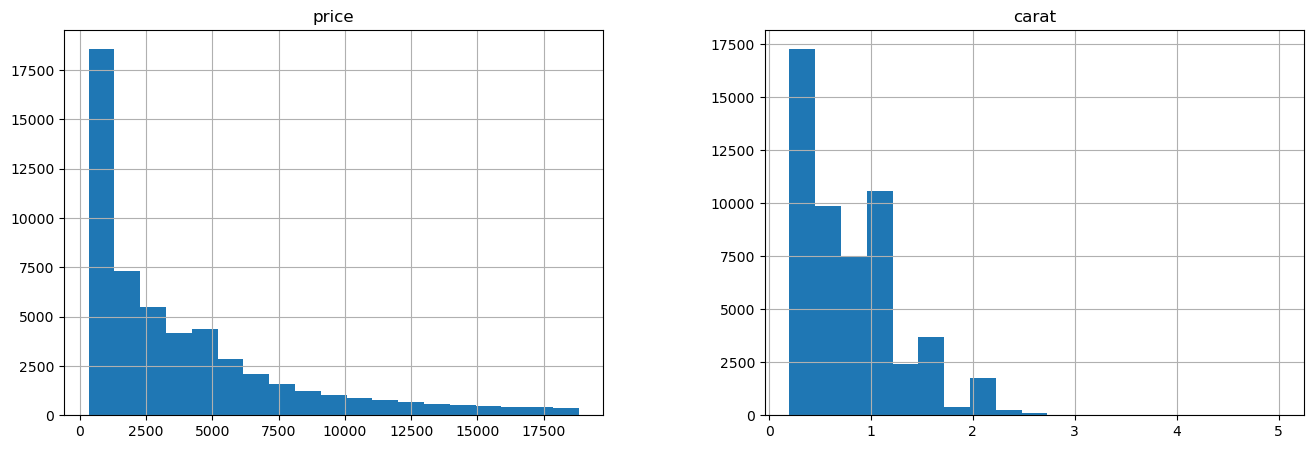

In [4]:
import matplotlib.pyplot as plt
from plotnine.data import diamonds

num_vars = ["price", "carat"]
diamonds[num_vars].hist(figsize=(16, 5), bins=19)
diamonds[num_vars].describe()

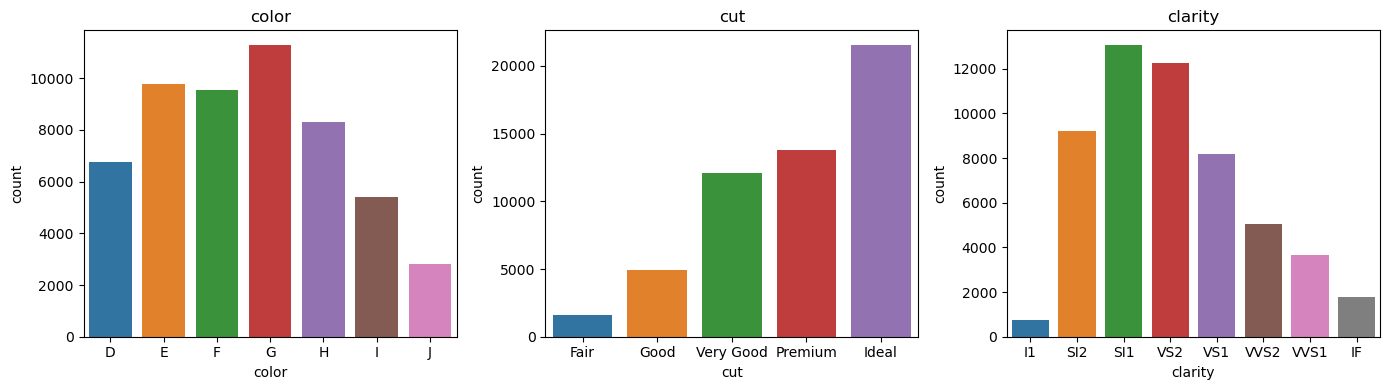

In [5]:
import seaborn as sns

cat_vars = ["color", "cut", "clarity"]

fig, ax = plt.subplots(ncols=3, figsize=(14, 4))
for i, x in enumerate(cat_vars):
    sns.countplot(data=diamonds, x=x, ax=ax[i]).set_title(x)
fig.tight_layout()

#### Associations with price

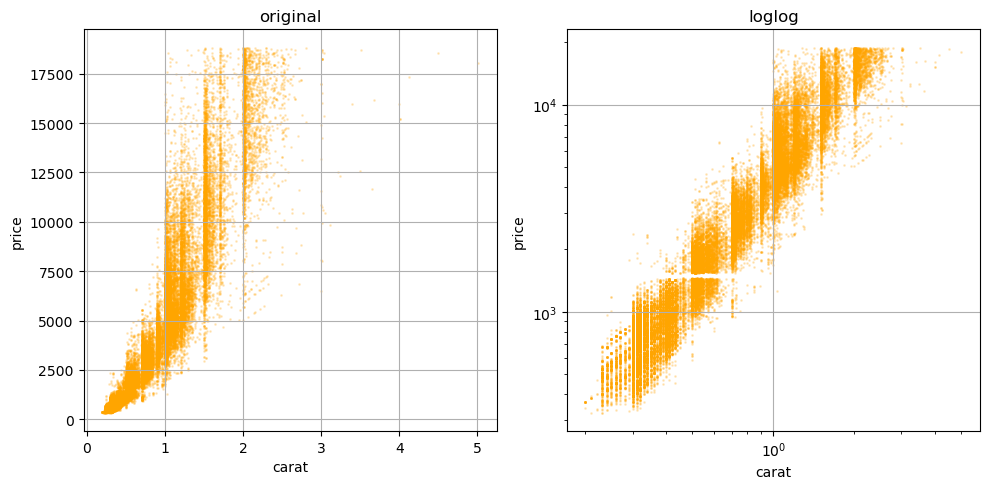

In [6]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))

for i, title in enumerate(("original", "loglog")):
    diamonds.plot.scatter(
        x="carat",
        y="price",
        alpha=0.2,
        color="orange",
        s=1,
        grid=True,
        loglog=bool(i),
        title=title,
        ax=ax[i],
    )
fig.tight_layout()

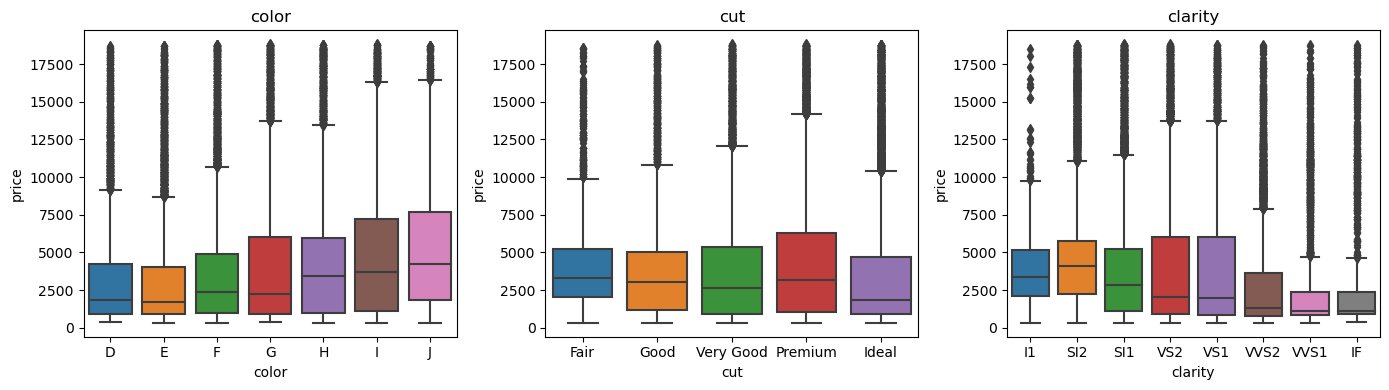

In [7]:
fig, ax = plt.subplots(ncols=3, figsize=(14, 4))

for i, x in enumerate(cat_vars):
    sns.boxplot(data=diamonds, x=x, y="price", ax=ax[i]).set_title(x)
fig.tight_layout()

**Comments**

- There are 53'940 observations in the diamonds data set.
- The average or mean diamond price is 3933 USD. About half of the diamonds cost less/more than the median of 2401 USD and about half of them cost between 950 USD (first quartile) and 5324 USD (third quartile). The lowest price is 326 USD, the highest price is 18'823 USD.
- Prices and carats show a *right-skewed* distribution with a few very large values.
- The relationship between price and carat seems quite strong and positive, which makes sense. On log-log scale, it looks linear.
- The worst categories of `color`, `cut`, and `clarity` are rare.
- Prices tend to be lower for nice colors, nice cuts as well as for nice clarities. This unintuitive behaviour will be entangled later by our regression models.

## Statistical models

The general modeling task is as follows: we want to approximate a *response variable* $Y$ by a function $f$ of $m$ *covariates* $X_1, \dots, X_m$, i.e.
$$
  Y \approx f(X_1, \dots, X_m).
$$
The function $f$ is unknown and we want to estimate it by $\hat f$ from observed data. 

Note: Think of the response $Y$ and the covariates $X_1, \dots, X_m$ as columns in a data set.

Normally, we are interested in modeling a specific property of $Y$, usually its expectation $E(Y)$ (= theoretic mean). In that case, we can make above approximate relationship more explicit by writing down the *model equation*
$$
  E(Y) = f(X_1, \dots, X_m).
$$

Once found, $\hat f$ serves as our prediction function that can be applied to fresh data. Furthermore, we can investigate the structure of $\hat f$ to gain insights about the relationship between response and covariates: what variables are especially important? how do they influence the response?

**Remark:** Other terms for "response variable" are "output", "target" or "dependent variable". Other terms for "covariate" are "input", "feature", "independent variable" or "predictor".

# Linear Regression

In order to get used to the terms mentioned above, we will look at the mother of all machine learning algorithms: (multiple) linear regression. It was first published by Adrien-Marie Legendre in 1805 [1] and is still very frequently used thanks to its simplicity, interpretability, and flexibility. It further serves as a simple benchmark for more complex algorithms and is the starting point for extensions like the generalized linear model.

## Model equation

The model equation of the linear regression is as follows:
$$
  E(Y) = f(X_1, \dots, X_m) = \beta_0 + \beta_1 X_1 + \cdots + \beta_m X_m.
$$
It relates the covariates $X_1, \dots, X_m$ to the expected response $E(Y)$ by a *linear* formula in the parameters $\beta_0, \dots, \beta_m$. The additive constant $\beta_0$ is called the *intercept*. The parameter $\beta_j$ tells us by how much $Y$ is expected to change when $X_j$ is increased by 1, **keeping all other covariates fixed** ("Ceteris Paribus"). Indeed:
$$
  E(Y \mid X_j = x + 1) - E(Y \mid X_j = x) = \beta_j (x + 1) - \beta_j x = \beta_j.
$$
The parameter $\beta_j$ is called *effect* of $X_j$ on the expected response $E(Y)$.

A linear regression with just one covariate is called a *simple* linear regression with equation 
$$
  E(Y) = \alpha + \beta X.
$$

## Least-squares

The optimal $\hat f$ to estimate $f$ is found by minimizing the sum of squared *prediction errors* resp. *residuals*
$$
  \sum_{i=1}^n e_i^2 = \sum_{i=1}^n (y_i - \hat y_i)^2.
$$
$y_i$ is the observed response of observation $i$ and $\hat y_i$ its prediction (or *fitted value*)
$$
  \hat y_i = \hat f(\text{Values of covariates of observation } i).
$$

Once the model is fitted, we can use the coefficients $\hat\beta_0, \dots, \hat\beta_m$ to make predictions and to study empirical effects of the covariates on the expected response.

### Example: simple linear regression

In order to discuss the typical output of a linear regression, we will now model diamond prices by their size. The model equation is
$$
  E(\text{price}) = \alpha + \beta \cdot \text{carat}.
$$

**A note on statsmodels and scikit-learn**

In this chapter, we will use two different packages to fit models. It is important to get used to both of them.

1) [statsmodels](https://www.statsmodels.org/stable/index.html): Contains different types of linear models, an R-like formula interface and extensive statistics output.
2) [scikit-learn](https://scikit-learn.org/stable/): The most important ML bundle for Python. When it comes to linear models, it requires more coding than `statsmodels` and provides less output. It will shine in later chapters, so it is important to get used to it already here.

When fitting linear regressions with least-squares, both packages use the same SVD-based linear algebra solver. On the other hand, GLMs are fitted with very different approaches: statsmodels uses IRLS, while scikit-learn uses L-BFGS.
 
At the beginning of an example, we will indicate which approach is being used.

In [8]:
# Approach 1: via scikit-learn
from plotnine.data import diamonds
from sklearn.linear_model import LinearRegression

# Initialize and fit linear regression
X = diamonds[["carat"]]
y = diamonds["price"]

model = LinearRegression()
model.fit(X, y)

# Coefficients
a, b = model.intercept_, model.coef_[0]
print("Fitted parameters", f"-Intercept: {a:.3f}", f"-Slope: {b:.3f}", sep="\n")

Fitted parameters
-Intercept: -2256.361
-Slope: 7756.426


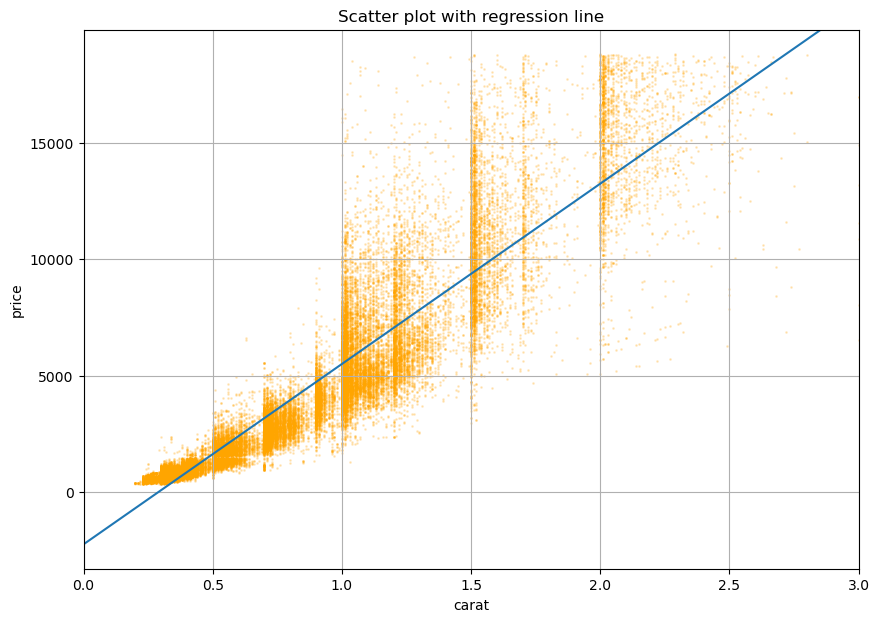

In [9]:
# Scatter plot with regression line
ax = diamonds.plot.scatter(
    x="carat",
    y="price",
    alpha=0.2,
    color="orange",
    s=1,
    grid=True,
    title="Scatter plot with regression line",
    figsize=(10, 7),
    xlim=(0, 3),
)
_ = ax.axline((0, a), slope=b)

In [10]:
# Calculate a prediction, i.e., a value on the regression line
import pandas as pd

one_row = pd.DataFrame({"carat": [1.3]})
print(
    "Prediction for 1.3 carat diamond?",
    f"-Using 'predict': {model.predict(one_row)[0]:.3f}",
    f"-By hand:         {a + 1.3*b:.3f}",
    sep="\n",
)

Prediction for 1.3 carat diamond?
-Using 'predict': 7826.993
-By hand:         7826.993


In [11]:
# Approach 2: via statsmodels
from plotnine.data import diamonds
from statsmodels.formula.api import ols

model2 = ols("price ~ carat", data=diamonds).fit()
model2.params

Intercept   -2256.360580
carat        7756.425618
dtype: float64

**Comments**

- **Regression coefficients:** The intercept $\alpha$ is estimated by $\hat \alpha = -2256$ and the effect of carat $\beta$ by $\hat \beta = 7756$ USD. This means that a 1 carat increase goes along with an average increase in price of 7756 USD. Similarly, we could say that a 0.1 increase in carat is associated with an increase in the price of 775.6 USD.
- **Regression line:** For a simple linear regression, the estimated regression coefficients $\hat \alpha$ and $\hat \beta$ can be visualized as a regression line. The latter represents the scatterplot as good as possible in the sense that the sum of squared vertical distances from the points to the line are minimal. The $y$-value at $x = 0$ equals $\hat \alpha = -2256$ and the slope of the line is $\hat \beta = 7756$.
- **Predictions:** Model predictions are made by using the fitted model equation $-2256 + 7756 \cdot \text{carat}$. For a diamond of size 1.3 carat, we get $-2256 + 1.3 \cdot 7756 \approx 7827$. These values correspond to the values on the regression line.

## Quality of the model

How good is a specific linear regression model? We may consider two aspects, namely 

- its predictive performance and 
- how well its assumptions are valid.

### Predictive performance

How precise are the model predictions? I.e., how well do predictions correspond with the observed response? In line with the least-squares approach, this is best quantified by the sum of squared prediction errors
$$
  \sum_{i = 1}^n (y_i - \hat y_i)^2
$$
or, equivalently, by the *mean-squared-error*
$$
  \text{MSE} = \frac{1}{n}\sum_{i = 1}^n (y_i - \hat y_i)^2.
$$
To quantify the size of the typical prediction error on the same scale as $Y$, we can take the square-root of the MSE and study the *root-mean-squared error* (RMSE). Minimizing MSE also minimizes RMSE.

Remark: The squared error, i.e., the function that quantifies the prediction error or *loss* of a single observation, is an example of a *loss function*. Later, we will meed other loss functions. 
Generally speaking, supervised ML algorithms try to minimize as objective function the total (or average) loss over the training sample, eventually adding a regularization penalty against overfitting. Overfitting is the tendency of the model to learn the training dataset by heart, i.e., it performs much better on the training data than on unseen data. The losses can be weighted in order to deal with case weights.

Besides an *absolute* performance measure like the RMSE, we gain additional insights by studying a relative performance measure like the **R-squared**. It measures the relative decrease in MSE compared to the MSE of the "empty" or "null" model consisting only of an intercept. Put differently, the R-squared measures the proportion of variability of $Y$ explained by the covariates.

#### Example: simple linear regression (continued)

Let us calculate these performance measures for the simple linear regression above.


In [12]:
# Via scikit-learn model
from sklearn.metrics import mean_squared_error as mse

print(f"RMSE: {mse(y, model.predict(X), squared=False):.3f}")
print(f"R-squared: {model.score(X, y):.2%}")

RMSE: 1548.533
R-squared: 84.93%


**Comments**

- **RMSE:** The RMSE is 1549 USD. This means that residuals (= prediction errors) are typically around 1549 USD.
- **R-squared:** The R-squared shows that about 85% of the price variability can be explained by variability in carat.

### Model assumptions

The main assumption of linear regression is a **correctly specified model equation** in the sense that predictions are not systematically too high or too small for certain values of the covariates. In a simple regression setting, this means that the points in the scatterplot are located *around* the regression line for all covariate values. For a multiple linear regression, this translates to the empirical condition that residuals (differences between observed and fitted response) do not show bias if plotted against covariate values.

Additional assumptions like independence of rows, constant variance of the error term $\varepsilon$ in the equation
$$
  Y = f(X_1, \dots, X_m) + \varepsilon
$$
and normal distribution of $\varepsilon$ guarantee optimality of the least-squares estimator $\hat \beta_0, \dots, \hat\beta_m$ and the correctness of inferential statistics (standard errors, p values, confidence intervals). In that case, we talk of the *normal linear model*. Its conditions are checked by studying *diagnostic plots*. We skip this part for brevity and since we are not digging into inferential statistics.

#### Example: simple linear regression (continued)

When looking at the scatter plot enhanced with the regression line from above, we can spot systematically too low (even negative!) predictions for very small diamonds. This indicates a wrongly specified model. Later, we will see ways to fix this.

## Typical problems

Here, we list some problems that frequently occurs with linear regression. We will only mention them without going into details.

### Missing values

Like many other ML algorithms, linear regression cannot deal with missing values. Rows with missing response can be safely dropped, while missing values in covariates should usually be dealt with. The simplest (often too naive) approach is to fill missing values with a typical value such as the mean or the most frequent value.

### Outliers

Gross outliers in covariates can distort the result of the linear regression. Do not delete them, but try to reduce their effect by taking logarithms or by using more robust regression techniques. Outliers in the response can be problematic as well, especially for inferential statistics.

### Overfitting

If too many parameters are used in relation to the number of observations, the resulting model might look good but would not generalize well to new data. This is called overfitting. A small amount of overfitting is unproblematic. Do not fit a model with $m=100$ parameters on a data set with just $n=200$ rows. The resulting model would be garbage. A $n/m$ ratio of 50-100 is usually safe for stable estimation of parameters.

### Collinearity

If the association between two or more covariates is strong, their coefficients are difficult to interpret because the Ceteris Paribus clause is usually unnatural in such situations. In a house price model, for instance, it is unnatural to study the effect of an additional room, keeping living area fixed. This is even more problematic for causally dependent covariates: imagine a model with $x$ and $x^2$ as covariates. It would certainly not make sense to study the effect of $x$ while keeping $x^2$ fixed. 

Strong collinearity can be detected by looking at correlations across (numeric) covariates. It is mainly a problem when interpreting effects or for statistical inference of effects. Predictions or other "global" model characteristics like the R-squared are not affected.

Often, collinearity can be reduced by transforming the covariates in a way that makes the Ceteris Paribus clause natural. Instead of, e.g., using number of rooms and living area in a house price model, it might help to represent living area by the derived variable "living area per room".

Note: Perfectly collinear covariates (for example $X$ and $2X$) cannot be used for algorithmic reasons.

## Categorical covariates

Since algorithms usually only understand numbers, categorical variables have to be encoded by numbers. The standard approach is called **one-hot-encoding** (OHE) and works as follows: Each level $x_k$ of the categorical variable $X$ gets its own binary **dummy** variable $D_k = 1(X = x_k)$, indicating if $X$ has this particular value or not. In linear models, one of the dummy variables ($D_1$, say) needs to be dropped due to perfect collinearity (for each row, the sum of OHE variables is always 1). Its level is automatically being represented by the intercept. This variant of OHE is called **dummy coding**.

For our diamonds data set, OHE for the variable `color` looks as follows (the first column is the original categorical variable, the other columns are the dummy variables):

![](../figs/ohe.PNG)

**Comments on categorical covariates**

- **Interpretation:** Interpreting the regression coefficient $\beta_k$ of the dummy variable $D_k$ is nothing special: It tells us how much $E(Y)$ changes when the dummy variable switches from 0 to 1. This amounts to switching from the reference category (the one without dummy) to category $k$.
- **Integer encoding:** Ordinal categorical covariates are sometimes integer encoded for simplicity, i.e., each category is represented by an integer number. 
- **Small categories:** In order to reduce overfitting, small categories are sometimes combined to a level "Other" or are added to the largest category.

### Example: dummy coding

Let us now extend the simple linear regression for diamond prices by adding dummy variables for the categorical covariate `color`.

In [13]:
# Approach 1: via statsmodels
from plotnine.data import diamonds
from statsmodels.formula.api import ols

model = ols("price ~ carat + color", data=diamonds).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                 4.893e+04
Date:                Fri, 11 Nov 2022   Prob (F-statistic):               0.00
Time:                        11:28:32   Log-Likelihood:            -4.6998e+05
No. Observations:               53940   AIC:                         9.400e+05
Df Residuals:                   53932   BIC:                         9.400e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2136.2289     20.122   -106.162      0.000   -2175.669   -2096.789
color[T.E]   -93.7813     23.252     -4.033      0.000    -139.355     -48.208
color[T.F]   -80.2629     23.405     -3.429      0.001    -126.136     -34.390
color[T.G]   -85.5363     22.670     -3.773      0.000    -129.969     -41.103
color[T.H]  -732.2418     24.354    -30.067      0.000    -779.975    -684.508
color[T.I] -1055.7319     27.310    -38.657      0.000   -1109.260   -1002.203
color[T.J] -1914.4722     33.777    -56.679      0.000   -1980.676   -1848.268
carat       8066.6230     14.040    574.558      0.000    8039.105    8094.141
==============================================================================
Omnibus:                    12266.990   Durbin-Watson:                   0.948
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           165317.069
Skew:                           0.719   Prob(JB):                         0.00
Kurtosis:                      11.455   Cond. No.                         11.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
# Approach 2: via scikit-learn
import pandas as pd
from plotnine.data import diamonds
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn import set_config

set_config(display="diagram")

# Initialize and fit regression "pipeline" with dummy encoding as
# preprocessing. Like this, the preprocessing will become part of
# the model object.
model2 = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("linear", "passthrough", ["carat"]),
            ("dummies", OneHotEncoder(drop="first"), ["color"]),
        ],
        verbose_feature_names_out=False,
    ),
    LinearRegression(),
)
model2.fit(diamonds, y=diamonds["price"])

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('linear', 'passthrough',
                                                  ['carat']),
                                                 ('dummies',
                                                  OneHotEncoder(drop='first'),
                                                  ['color'])],
                                   verbose_feature_names_out=False)),
                ('linearregression', LinearRegression())])

In [15]:
# Extract coefficients per feature
print("Intercept:", model2[-1].intercept_)
results = pd.DataFrame(
    model2[-1].coef_,
    columns=["Estimates"],
    index=model2[:-1].get_feature_names_out(),
)
results

Intercept: -2136.228853437469


,Estimates
carat,8066.623019
color_E,-93.781288
color_F,-80.262858
color_G,-85.536282
color_H,-732.241826
color_I,-1055.731857
color_J,-1914.472203


**Comments**

- **Slope:** Adding the covariate `color` has changed the slope of `carat` from 7756 in the simple linear regression to 8067. This is the effect of `carat` *adjusted* for `color`.
- **Effects:** Each dummy variable of `color` has received its own coefficient. Switching from the reference color "D" to "E" is associated with a price reduction of 94 USD. The effect of color "F" compared to color "D" is about -80 USD.
- **Confounding:** In contrast to the unintuitive descriptive result (worse colors tend to higher prices), worse colors are associated with lower prices now. Adjusting for carat has solved that mystery. It seems that the diamond size had *confounded* the association between color and price. A regression model accounts for such confounding effects.

## Flexibility

Linear regression is flexible regarding *how* variables are represented in the linear equation. Possibilities include

- using non-linear terms,
- interactions, and
- transformations, notably logarithmic responses.

These elements are very important for making realistic models.

### Non-linear terms

Important numeric covariates might be represented by more than just one parameter (= linear slope) to allow for more flexible and non-linear associations to the response. Adding a squared term, e.g., allows for curvature, adding enough multiple polynomial terms can approximate any smooth relationship. 

For example, the model equation for a cubic regression is
$$
  E(Y) = \beta_0 + \beta_1 x + \beta_2 x^2 + \beta_3x^3.
$$
An alternative to polynomial terms are regression *splines*, i.e., piecewise polynomials. Using non-linear terms makes interpretation of regression coefficients difficult. An option is to study predictions while sliding the covariate values over its range (systematic predictions).

#### Example: cubic regression

How would a cubic regression approximate the relationship between diamond prices and carat?

The polynomial terms used for modeling look as follows:

![](../figs/cubic.PNG)

And here the model including systematic predictions.


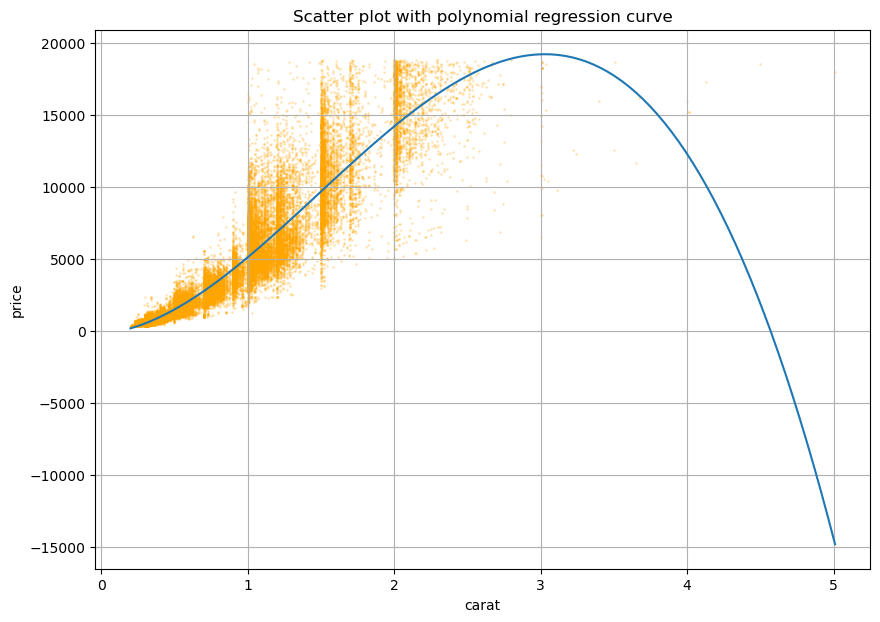

In [16]:
# Via scikit-learn
import numpy as np
from plotnine.data import diamonds
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

X = diamonds[["carat"]].to_numpy()
y = diamonds["price"]

# Fit cubic linear regression
model = make_pipeline(PolynomialFeatures(3), LinearRegression())
model.fit(X, y)

# Scatter plot with regression curve
ax = diamonds.plot.scatter(
    x="carat",
    y="price",
    alpha=0.2,
    color="orange",
    s=1,
    grid=True,
    title="Scatter plot with polynomial regression curve",
    figsize=(10, 7),
)
x_plot = np.linspace(X.min(), X.max(), 100)
_ = ax.plot(x_plot, model.predict(x_plot[:, np.newaxis]))

**Comments**

- In the dense part (carats up to 2), the cubic polynomial seems to provide better results than a simple linear regression. No clear bias is visible.
- Extrapolation to diamonds above 2 carat provides catastrophic results. Thus, be cautious with polynomial terms and extrapolation.

### Interaction terms

Once fitted, the effect of a covariate does not depend on the values of the other covariates. This is a direct consequence of the additivity of the model equation. The additivity assumption is sometimes too strict. E.g., treatment effects might be larger for younger patients than for older. Or an extra 0.1 carat of diamond weight is worth more for a beautiful white diamond compared to an unspectacular yellow one. In such cases, adding *interaction terms* provides the necessary flexibility. Mathematically, an interaction term between covariates $X$ and $Z$ equals their product. Practically, it means that the effect $X$ depends on the value of $Z$. 

**Comments**

- Adding interaction terms makes model interpretation difficult.
- Interaction terms mean more parameters, thus there is a danger of overfitting. Finding the right interaction terms without introducing overfitting is difficult or even impossible.
- Modern ML algorithms like neural networks and tree-based models automatically find interactions, even between more than two variables. This is one of their main strengths.

#### Example: interactions

Let us now fit a linear regression for diamond prices with covariates `carat` and `color`, once without and once with interaction. We interpret the resulting models by looking at systematic predictions (sliding both carat and color over their range).

,carat,color,variable,prediction
0,0.3,E,no_interaction,189.976765
1,0.3,I,no_interaction,-771.973804
2,0.3,J,no_interaction,-1630.714150
3,0.3,H,no_interaction,-448.483773
4,0.3,F,no_interaction,203.495194


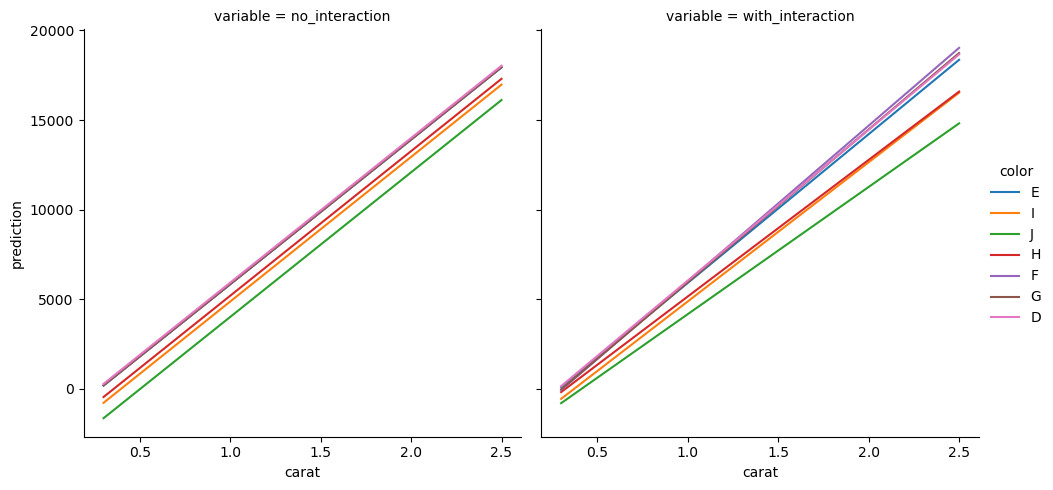

In [17]:
# Via statsmodels
import numpy as np
import pandas as pd
import itertools
import statsmodels.formula.api as sfm
import seaborn as sns
from plotnine.data import diamonds

no_interaction = sfm.ols("price ~ carat + color", data=diamonds).fit()
with_interaction = sfm.ols("price ~ carat * color", data=diamonds).fit()

# Create dataset with systematic predictions
# R's expand.grid: https://pandas.pydata.org/docs/user_guide/cookbook.html
def expand_grid(data_dict):
    rows = itertools.product(*data_dict.values())
    return pd.DataFrame.from_records(rows, columns=data_dict.keys())


combos = {"carat": np.linspace(0.3, 2.5, 100), "color": diamonds.color.unique()}

to_plot = (
    expand_grid(combos)
    .assign(
        no_interaction=lambda x: no_interaction.predict(x),
        with_interaction=lambda x: with_interaction.predict(x),
    )
    .melt(id_vars=["carat", "color"], value_name="prediction")
)

# Plot the predictions
sns.relplot(
    data=to_plot, x="carat", y="prediction", col="variable", hue="color", kind="line"
)

# Show some lines
to_plot.head()

**Comments**

- The left image shows an additive model: the slope of `carat` does not depend on the color. Similarly, the effect of `color` does not depend on the size. This is not very realistic as color effects are expected to be larger for large diamonds.
- In the model with interactions (right image), we get different slopes and intercepts per color, just as if we would have fitted a simple linear regression *per color*. The larger the diamonds, the larger the color effects.
- The slopes are not very much different across colors, so the interaction effects are small.

### Transformations of covariates

Covariates are often transformed before entering the model:

- Categorical covariates are dummy coded.
- Strongly correlated covariates might be decorrelated by forming ratios.
- Logarithms neutralize gross outliers.

Not surprisingly, coefficients explain how the *transformed* variables acts on the expected response. For a log-transformed covariate $X$, we can even interpret the coefficient regarding the **untransformed** $X$. In the model equation
$$
  E(Y\mid X = x) = \alpha + \beta \log(x),
$$
we can say: A 1% increase in $X$ leads to an increase in $E(Y)$ of about $\beta/100$. Indeed, we have
$$
  E(Y\mid X = 101\% \cdot x) - E(Y\mid X = x) = \alpha + \beta \log (1.01 \cdot x) - \alpha - \beta \log(x) \\ 
  = \beta \log\left(\frac{1.01 \cdot x}{x}\right)= \beta \log(1.01) \approx \beta/100.
$$
Thus, taking logarithms of covariates not only deals with outliers, it also offers us the possibility to talk about percentages.

#### Example: log(carat)

What would our simple linear regression provide with logarithmic carat as single covariate?


Intercept: 6237.837
Slope: 5836.025
R-squared: 73.2%
RMSE: 2065.555


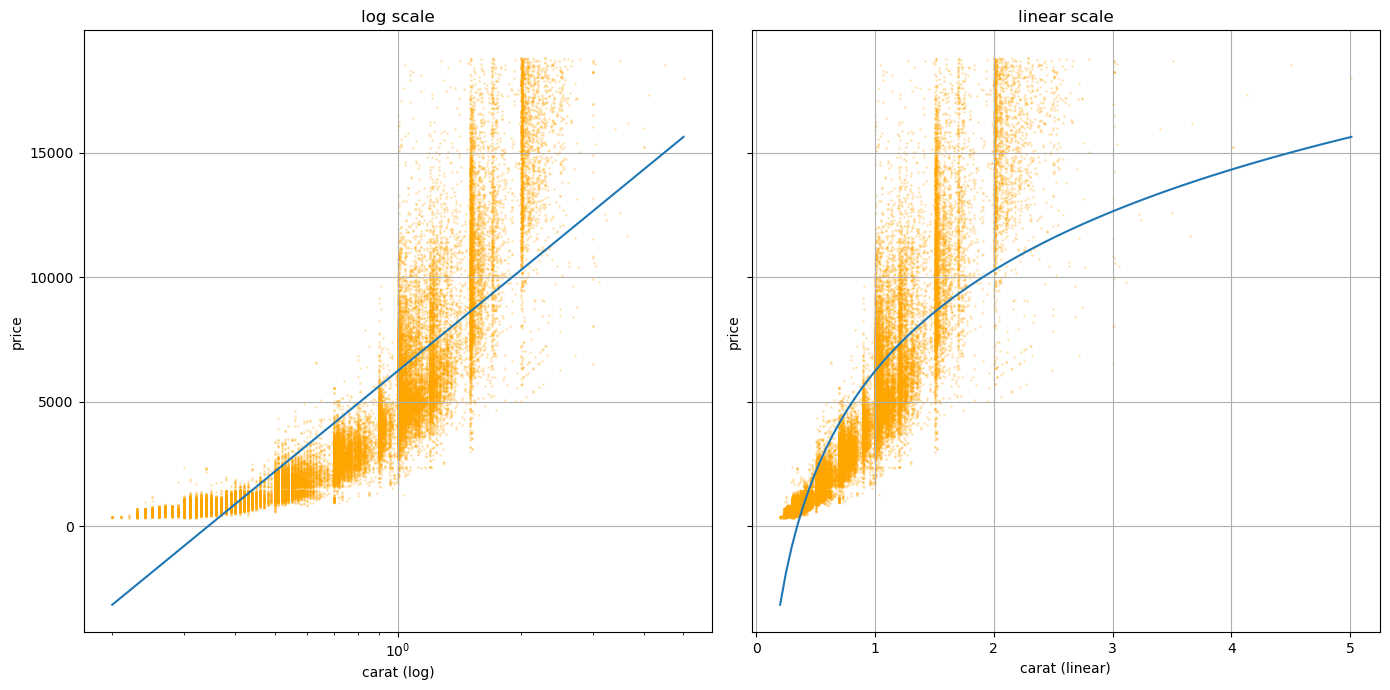

In [18]:
# Via scikit-learn
import numpy as np
import matplotlib.pyplot as plt
from plotnine.data import diamonds
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline

X = diamonds[["carat"]].to_numpy()
y = diamonds["price"]

# Fit linear regression
model = make_pipeline(FunctionTransformer(np.log), LinearRegression())
model.fit(X, y)

# Results
print(
    f"Intercept: {model[-1].intercept_:.3f}",
    f"Slope: {model[-1].coef_[0]:.3f}",
    f"R-squared: {model.score(X, y):.1%}",
    f"RMSE: {mse(y, model.predict(X), squared=False):.3f}",
    sep="\n",
)

# Scatter plots with regression curve (with and without log)
fig, axes = plt.subplots(ncols=2, figsize=(14, 7), sharey=True)
x_plot = np.linspace(X.min(), X.max(), 100)
pred = model.predict(x_plot[:, np.newaxis])

for ax, xscale in zip(axes, ("log", "linear")):
    ax.scatter(X, y, color="orange", alpha=0.2, s=1)
    ax.set_xscale(xscale)
    ax.plot(x_plot, pred)
    ax.set(title=xscale + " scale", xlabel=f"carat ({xscale})", ylabel="price")
    ax.grid()
fig.tight_layout()

**Comments** 

- Indeed, we have fitted a logarithmic relationship between carat and price. The scatterplots (on log-scale and back-transformed to original scale) reveal that this does not make much sense. The model looks wrong. Shouldn't we better take the logarithm of *price*?
- As usual, we can say that a one-point increase in `log(carat)` leads to a expected price increase of 5836 USD.
- Back-transformed, this amounts to saying that a 1% increase in `carat` is associated with a price increase of about 5836/100 = 60 USD.

### Logarithmic response

We have seen that taking logarithms not only reduces outlier effects in covariates but they also allow to think in percentages. What happens if we log-transform the response variable? The model of a simple linear regression would be
$$
  E(\log(Y) \mid X = x) = \alpha + \beta x.
$$  
**Claim:** The effect $\beta$ tells us by how much *percentage* we can expect $Y$ to change when increasing $X$ by 1. Thus, a logarithmic response leads to a *multiplicative* instead of an *additive* model.

**Proof**

Assume for a moment that we can swap taking expectations and logarithms (disclaimer: we cannot). In that case, the model would be

$$
  \log(E(Y\mid X = x)) = \alpha + \beta x
$$
or, after exponentiation,
$$
  E(Y\mid X = x) =e^{\alpha + \beta x}.
$$
The additive effect of increasing $X$ by 1 would be
$$
  E(Y\mid X = x+1) - E(Y\mid X = x) = e^{\alpha + \beta (x+1)} - e^{\alpha + \beta x} \\
  = e^{\alpha + \beta x}e^\beta - e^{\alpha + \beta x} = e^{\alpha + \beta x}(e^\beta - 1) = E(Y\mid X = x)(e^\beta - 1).
$$
Dividing both sides by $E(Y\mid X = x)$ gives
$$
\underbrace{\frac{E(Y\mid X = x+1) - E(Y\mid X = x)}{E(Y\mid X = x)}}_{\text{Relative change in } E(Y)} = e^\beta-1 \approx \beta = \beta \cdot 100\%.
$$
Indeed: A one point increase in $X$ is associated with a relative increase in $E(Y)$ of about $\beta \cdot 100\%$.

Since expectations and logarithms cannot be swapped, the calculation is not 100% correct. One consequence of this imperfection is that predictions backtransformed to the scale of $Y$ are biased. One of the motivations of the generalized linear models GLM (see next section) will be to mend this problem in an elegant way.

#### Example: log(price)

How would our simple linear regression look like with `log(price)` as response?

Intercept: 6.215
Slope: 1.970
R-squared: 84.7%
RMSE: 0.397


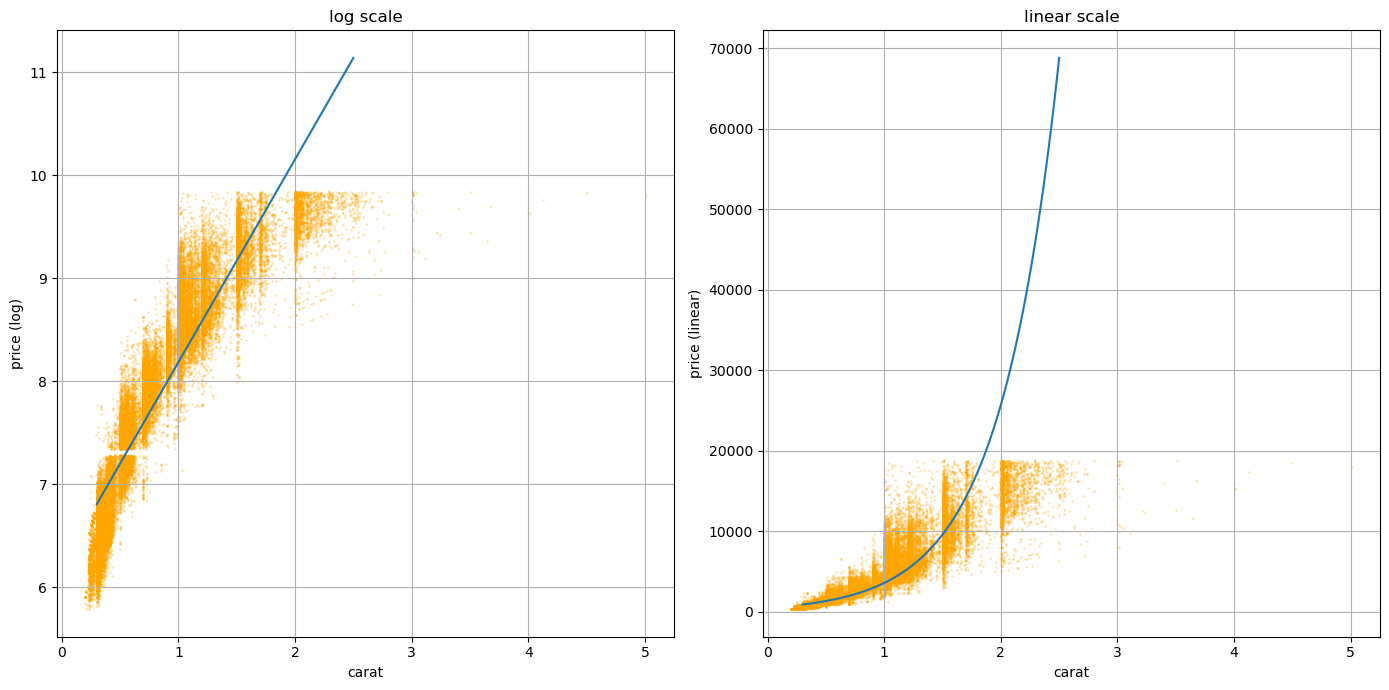

In [19]:
# Via scikit-learn
import numpy as np
import matplotlib.pyplot as plt
from plotnine.data import diamonds
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse

X = diamonds[["carat"]].to_numpy()
y = np.log(diamonds["price"])

# Fit linear regression
model = LinearRegression()
model.fit(X, y)

# Results
print(
    f"Intercept: {model.intercept_:.3f}",
    f"Slope: {model.coef_[0]:.3f}",
    f"R-squared: {model.score(X, y):.1%}",
    f"RMSE: {mse(y, model.predict(X), squared=False):.3f}",
    sep="\n",
)

# Scatter plots with regression curve (with and without log)
fig, axes = plt.subplots(ncols=2, figsize=(14, 7), sharex=True)
x_plot = np.linspace(0.3, 2.5, 100)
pred = model.predict(x_plot[:, np.newaxis])

for ax, yscale, f in zip(axes, ("log", "linear"), (lambda x: x, np.exp)):
    ax.scatter(X, f(y), color="orange", alpha=0.2, s=1)
    ax.plot(x_plot, f(pred))
    ax.set(title=yscale + " scale", xlabel="carat", ylabel=f"price ({yscale})")
    ax.grid()
fig.tight_layout()

**Comments** 

- **General impression:** The model looks fine until 1.8 carat (both on log-scale and original scale). For larger diamonds, the model is heavily biased.
- **Interpretation on log-scale:** An increase in carat of 0.1 is associated with a log(price) increase of 0.197.
- **Interpretation on original scale:** An increase in carat of 0.1 is associated with a price increase of about 20%.
- **Predictions:** Predictions are obtained by exponentiating the result of the linear formula.
- **R-squared:** About 85% of the variability in log(price) can be explained by carat.
- **RMSE:** Typical prediction errors are in the range of 40%.

#### Example: log(carat) and log(price)

Using logarithms for either price or carat did not provide a satisfactory model yet. What about applying logarithms to both response and covariate at the same time?

Intercept: 8.449
Slope: 1.676
R-squared: 93.3%
RMSE: 0.263
Relative bias on original scale: 3.1%


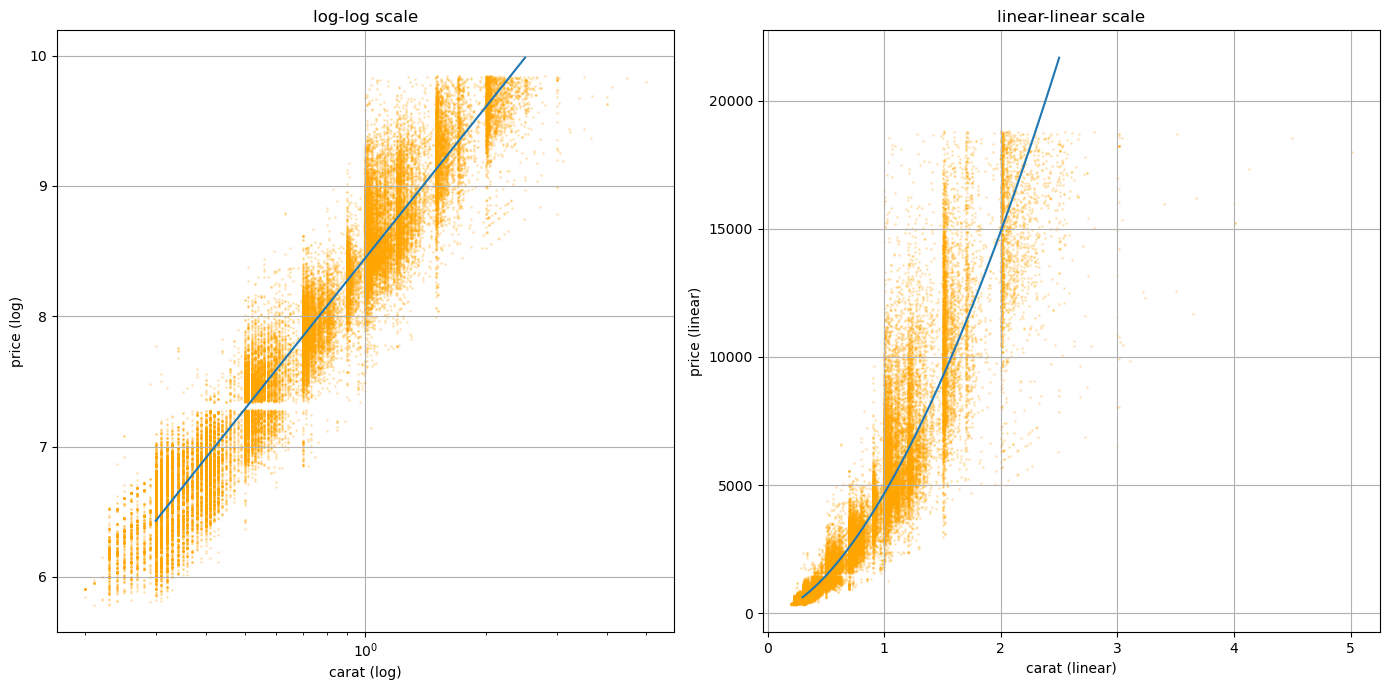

In [20]:
# Via scikit-learn
import numpy as np
import matplotlib.pyplot as plt
from plotnine.data import diamonds
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error as mse

X = diamonds[["carat"]].to_numpy()
y = np.log(diamonds["price"])

# Fit linear regression
model = make_pipeline(FunctionTransformer(np.log), LinearRegression())
model.fit(X, y)

# Results
print(
    f"Intercept: {model[-1].intercept_:.3f}",
    f"Slope: {model[-1].coef_[0]:.3f}",
    f"R-squared: {model.score(X, y):.1%}",
    f"RMSE: {mse(y, model.predict(X), squared=False):.3f}",
    sep="\n",
)

# Scatter plots with regression curve (with and without log)
fig, axes = plt.subplots(ncols=2, figsize=(14, 7))
x_plot = np.linspace(0.3, 2.5, 100)
pred = model.predict(x_plot[:, np.newaxis])

for ax, scale, f in zip(axes, ("log", "linear"), (lambda x: x, np.exp)):
    ax.scatter(X, f(y), color="orange", alpha=0.2, s=1)
    ax.set_xscale(scale)
    ax.plot(x_plot, f(pred))
    ax.set(
        title=f"{scale}-{scale} scale",
        xlabel=f"carat ({scale})",
        ylabel=f"price ({scale})",
    )
    ax.grid()
fig.tight_layout()

# Relative bias on original scale
bias = (diamonds["price"]).mean() / (np.exp(model.predict(X))).mean() - 1
print(f"Relative bias on original scale: {bias:.1%}")

**Comments** 

- **General impression:** The model looks quite realistic, both on log-log and back-transformed scale. There are no obvious model biases visible.
- **Effect on log-scales**: An increase in log(carat) of 1 is associated with a log(price) increase of 1.67.
- **Effect on original scales**: An increase in carat of 1% is associated with a price increase of about 1.67%. Such a log-log effect is called *elasticity*.
- **R-squared:** About 93% of the variability in log(price) can be explained by log(carat). The model performs much better than the ones in the previous examples.
- **RMSE:** Typical prediction errors are in the range of 26%.
- **Bias:** While unbiased on the log scale, the predictions of this model are about 3% too small after exponentiation. This can be fixed by applying a corresponding bias correction factor.

## Example: diamonds improved

To end the section on linear regression, we extend the log-log-example above by adding `color`, `cut` and `clarity` as categorical covariates.

In [21]:
# Approach 1: via statsmodels
import numpy as np
from plotnine.data import diamonds
from statsmodels.formula.api import ols

formula = "np.log(price) ~ np.log(carat) + color + cut + clarity"
model = ols(formula, data=diamonds).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(price)   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                 1.693e+05
Date:                Fri, 11 Nov 2022   Prob (F-statistic):               0.00
Time:                        11:28:39   Log-Likelihood:                 31967.
No. Observations:               53940   AIC:                        -6.390e+04
Df Residuals:                   53921   BIC:                        -6.373e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            7.8569      0.006   1364.426      0.000       7.846       7.868
color[T.E]          -0.0543      0.002    -25.622      0.000      -0.058      -0.050
color[T.F]          -0.0946      0.002    -44.160      0.000      -0.099      -0.090
color[T.G]          -0.1604      0.002    -76.492      0.000      -0.164      -0.156
color[T.H]          -0.2511      0.002   -112.850      0.000      -0.255      -0.247
color[T.I]          -0.3726      0.002   -149.504      0.000      -0.377      -0.368
color[T.J]          -0.5110      0.003   -166.236      0.000      -0.517      -0.505
cut[T.Good]          0.0800      0.004     20.575      0.000       0.072       0.088
cut[T.Very Good]     0.1172      0.004     32.392      0.000       0.110       0.124
cut[T.Premium]       0.1393      0.004     38.937      0.000       0.132       0.146
cut[T.Ideal]         0.1612      0.004     45.439      0.000       0.154       0.168
clarity[T.SI2]       0.4279      0.005     82.637      0.000       0.418       0.438
clarity[T.SI1]       0.5930      0.005    115.165      0.000       0.583       0.603
clarity[T.VS2]       0.7422      0.005    143.342      0.000       0.732       0.752
clarity[T.VS1]       0.8123      0.005    154.523      0.000       0.802       0.823
clarity[T.VVS2]      0.9473      0.005    174.828      0.000       0.937       0.958
clarity[T.VVS1]      1.0187      0.006    182.731      0.000       1.008       1.030
clarity[T.IF]        1.1137      0.006    184.695      0.000       1.102       1.126
np.log(carat)        1.8837      0.001   1668.750      0.000       1.882       1.886
==============================================================================
Omnibus:                     3721.869   Durbin-Watson:                   1.245
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15890.209
Skew:                           0.210   Prob(JB):                         0.00
Kurtosis:                       5.626   Cond. No.                         33.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
# Approach 2: via scikit-learn
import numpy as np
import pandas as pd
from plotnine.data import diamonds
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error as mse

y = np.log(diamonds["price"])

# Categorical variables to dummy encode and their natural order
cat_vars = ["color", "cut", "clarity"]
lvl = [diamonds[x].cat.categories.to_list() for x in cat_vars]

# Initialize and fit regression
take_log = FunctionTransformer(np.log, feature_names_out="one-to-one")
model2 = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("log_carat", take_log, ["carat"]),
            ("dummies", OneHotEncoder(categories=lvl, drop="first"), cat_vars),
        ],
        verbose_feature_names_out=False,
    ),
    LinearRegression(),
)
model2.fit(diamonds, y)

# Performance
print(f"RMSE: {mse(y, model2.predict(diamonds), squared=False):.3f}")
print(f"R-squared: {model2.score(diamonds, y):.2%}")

# Extract coefficients per feature
print("Intercept", model2[-1].intercept_)
results = pd.DataFrame(
    model2[-1].coef_, columns=["Estimates"], index=model2[:-1].get_feature_names_out()
)
results

RMSE: 0.134
R-squared: 98.26%
Intercept 7.856855782011679


,Estimates
carat,1.883718
color_E,-0.054277
color_F,-0.094596
color_G,-0.160378
color_H,-0.251071
color_I,-0.372574
color_J,-0.510983
cut_Good,0.080048
cut_Very Good,0.117215
cut_Premium,0.139345


**Comments**

- **Effects:** All effects of the multiple linear regression look plausible.
- **Interpretation:** For every % more carat, we can expect an increase in price of about 1.9% (keeping everything else fixed). After all, a big diamond is worth more than its two halves. Diamonds with the second best color "E" are about 5% cheaper than those with the best color (keeping everything else fixed). The multiplicative effects of categorical covariates clearly make more sense here than the additive effects without logarithmic response.
- **R-squared:** About 98% of the variability in log-prices can be explained by our four covariates. Adding the three categorical covariates has considerably improved the precision of the model.
- **RMSE:** The typical prediction error is about 13%.

## Exercises

As alternative to the multiple linear regression on diamond prices with logarithmic price and logarithmic carat, consider the same model without logarithms. Interpret the output of the model. Does it make sense from a practical perspective?

# Generalized Linear Model

The linear regression model has many extensions:

- quantile regression to model quantiles of the response instead of its expectation,
- mixed-models to capture grouped data structures,
- generalized least-squares to model time series data,
- penalized regression, an extension to fight overfitting (LASSO, Ridge-Regression, Elastic-Net),
- neural networks that automatically learn interactions and non-linearities (see later),
- **the generalized linear model** that e.g. allows to model binary response variables in a natural way,
- ...

This section covers the generalized linear model (GLM). It was introduced in 1972 by Nelder & Wedderburn [2]. 

## Definition

The model equation of the GLM is
$$
  g(E(Y)) = \beta_0 + \beta_1 X_1 + \dots + \beta_m X_m,
$$
or similarly
$$
  E(Y) = g^{-1}(\beta_0 + \beta_1 X_1 + \dots + \beta_m X_m),
$$
where $Y$ conditional on the covariates belongs to the so-called exponential dispersion family and $g$ is a transformation. 

Thus, a GLM has three components:

1. A linear function of the covariates, exactly as in linear regression.
2. The link function $g$. Its purpose is to map $E(Y)$ to the scale of the linear function. Or the other way round: The inverse link $g^{-1}$ maps the linear part to the scale of the response.
3. A distribution of $Y$ conditional on the covariates. It implies the distribution-specific loss function $L$, called *unit deviance*, whose sum should be minimized over the model data.

The following table lists some of the most commonly used GLMs.

| Regression | Distribution| Range of $Y$          | Natural link            |  Unit deviance
|:----------:|:-----------:|:---------------------:|:-----------------------:|:----------------------------------------------
| Linear     | Normal      | $(-\infty, \infty)$   | Identity                | $(y - \hat y)^2$
| Logistic   | Binary      | $\{0, 1\}$            | logit                   | $-2(y\log(\hat y) + (1-y) \log(1-\hat y))$
| Poisson    | Poisson     | $[0, \infty)$         | log                     | $2(y \log(y / \hat y) - (y - \hat y))$
| Gamma      | Gamma       | $(0, \infty)$         | $1/x$ (typical: log)    | $2((y - \hat y) / \hat y - \log(y / \hat y))$
| Multinomial| Multinomial | $\{C_1, \dots, C_m\}$ | mlogit                  | $-2\sum_{j = 1}^m 1(y = C_j)\log(\hat y_j)$

<img src="../figs/GLM_distributions.PNG" width="100%">

**Some remarks**

- To find predictions $\hat y$ on the scale of $Y$, one evaluates the linear function (called "linear predictor") and then applies the inverse link $g^{-1}$.
- Any transformation can be used as link $g$. However, only the *natural/canonical* link has the relevant property of providing unbiased predictions on the scale of $Y$ in the sense $E(\hat y) = E(Y)$. Thus, one usually works with the natural link. Notable exception is the Gamma GLM, which is mostly applied with the log link because of the next property.
- **Using a log link produces a multiplicative model for $E(Y)$.**
- The binary case makes use of the relation $E(Y) = \text{Prob(Y = 1)} = p$, i.e., modeling the expected response is the same as modeling the probability $p$ of having a 1.
- The multinomial regression generalizes the binary case to more than two categories. While binary logistic regression predicts one single probability $\text{Prob}(Y=1)$, the multinomial model predicts a probability $\hat y_j$ for each of the $m$ categories.
- The normal, Poisson and Gamma GLMs are special cases of the *Tweedie GLM*.
- Half of the multinomial/binary unit deviance is the same as the cross-entropy, also called log loss.

## Why do we need GLMs?

The normal linear model allows us to model $E(Y)$ by an additive linear function. In principle, this would also work for 

- binary responses (insurance claim yes/no, success yes/no, fraud yes/no, ...), 
- count responses (number of insurance claims, number of adverse events, ...),
- right-skewed responses (time durations, claim heights, prices, ...).

However, in such cases, an additive linear model equation is usually not very realistic. As such, the main assumption of the linear regression model is violated:

- Binary: A jump from 0.5 to 0.6 success probability seems less impressive than from 0.89 to 0.99. 
- Count: A jump from an expected count of 2 to 3 seems less impressive than a jump from an expected count of 0.1 to 1.1. 
- Right-skewed: A price jump from 1 Mio to 1.1 Mio is conceived as larger than a jump from 2 Mio to 2.1 Mio.

GLMs deal with such problems by using a suitable link function like the logarithm. At least for the first two examples, this could not be achieved by a linear regression with log response because log(0) is not defined.

Further advantages of the GLM over the linear regression are:

- Predictions are on the right scale: For instance, probabilities of a binary response are between 0 and 1 when using the logit link. With linear regression, they could be outside [0, 1]. Similarly, predictions of a Poisson or Gamma regression with log link are strictly positive, while they could be even negative with linear regression.
- Inferential statistics are less inaccurate. For the linear regression, they depend on the equal variance assumption which is violated for distributions like Poisson or Gamma.

## Interpretation of effects

The interpretation of model coefficients in GLMs is guided by the link function.

- **Identity link:** As with linear regression: "A one-point increase in $X$ is associated with a $\beta$ increase in $E(Y)$, keeping everything else fixed". 
- **Log link:** As with linear regression with log response: "A one-point increase in $X$ is associated with a relative increase in $E(Y)$ of $e^{\beta}-1 \approx \beta \cdot 100\%$. The derivation is exactly as we have seen for linear regression, except that we now start with $\log(E(Y))$ instead of $E(\log(Y))$, making the former calculations mathematically sound. Using a GLM with log link is thus the cleaner way to produce a multiplicative model for $E(Y)$ than to log transform the response in a linear regression.
- **Logit link:** Logistic regression uses the logit link
$$
  \text{logit}(p) = \log (\text{odds}(p)) = \log\left(\frac{p}{1-p}\right).
$$
It maps probabilities to the real line. The inverse logit ("sigmoidal transformation" or "logistic function") reverts this: It maps real values to the range from 0 to 1. Odds, i.e., the ratio of $p$ to $1-p$, is a concept borrowed from gambling: The *probability* to get a "6" is 1/6 whereas the *odds* to get a "6" is 1:5 = 0.2. By definition, logistic regression is an additive model for the log-odds, thus a multiplicative model for the odds of getting a 1. Correspondingly, the coefficients $e^\beta - 1 \approx \beta$ are called *odds ratios*. There is no easy way to interpret the coefficients on the original probability scale.

![](../figs/log_odds.png)

## Parameter estimation and deviance

Parameters of a GLM are estimated by Maximum-Likelihood. This amounts to minimizing the (total) *deviance*, which equals the sum of the unit deviances over the model data (eventually weighted by case weights). For the normal linear model, the total deviance is equal to $n$ times the MSE. In fact, the total deviance plays the same role for GLMs as the MSE does for linear regression. Consequently, it is sometimes useful to consider as a relative performance measure the relative deviance improvement compared to an intercept-only model. For the normal linear regression model, this *Pseudo-R-squared* corresponds to the usual R-squared.

**Outlook:** The loss functions used in the context of GLMs are used one-to-one as loss functions for other ML methods such as gradient boosting or neural networks. There, the "appropriate" loss function is chosen from the context. For example, if the response is binary, one usually chooses the binary cross-entropy as the objective function.

## Example: Poisson count regression

We now model claim counts for the `insuranceData` by a Poisson GLM with its natural link function, the log. It makes sure that we can interpret covariate effects on a relative scale and that predictions are positive.

In [23]:
import pandas as pd

car = pd.read_csv("car.csv")  # see readme how to get the data
car.head()

,veh_value,exposure,clm,numclaims,claimcst0,veh_body,veh_age,gender,area,agecat,_OBSTAT_
0,1.06,0.303901,0,0,0.0,HBACK,3,F,C,2,01101 0 0 0
1,1.03,0.648871,0,0,0.0,HBACK,2,F,A,4,01101 0 0 0
2,3.26,0.569473,0,0,0.0,UTE,2,F,E,2,01101 0 0 0
3,4.14,0.317591,0,0,0.0,STNWG,2,F,D,2,01101 0 0 0
4,0.72,0.648871,0,0,0.0,HBACK,4,F,C,2,01101 0 0 0


In [24]:
# Describe response and data
print("Distribution of the claim counts:")
print(car["numclaims"].value_counts())
car.describe()

Distribution of the claim counts:
0    63232
1     4333
2      271
3       18
4        2
Name: numclaims, dtype: int64


,veh_value,exposure,clm,numclaims,claimcst0,veh_age,agecat
count,67856.000000,67856.000000,67856.000000,67856.000000,67856.000000,67856.000000,67856.000000
mean,1.777021,0.468652,0.068144,0.072757,137.270167,2.673529,3.485484
std,1.205232,0.290025,0.251995,0.278204,1056.297768,1.067542,1.425608
min,0.000000,0.002738,0.000000,0.000000,0.000000,1.000000,1.000000
25%,1.010000,0.219028,0.000000,0.000000,0.000000,2.000000,2.000000
50%,1.500000,0.446270,0.000000,0.000000,0.000000,3.000000,3.000000
75%,2.150000,0.709103,0.000000,0.000000,0.000000,4.000000,5.000000
max,34.560000,0.999316,1.000000,4.000000,55922.129883,4.000000,6.000000


In [25]:
# Approach 1: via statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Deviance of intercept only model (= null deviance)
mod0 = smf.glm("numclaims ~ 1", data=car, family=sm.families.Poisson()).fit()
print(f"Null deviance: {mod0.deviance:.3f}")

# Fit model by IRLS
model = smf.glm(
    "numclaims ~ veh_value + veh_body + veh_age + gender + area + agecat",
    data=car,
    family=sm.families.Poisson(),
).fit()
model.summary()

Null deviance: 26768.303


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              numclaims   No. Observations:                67856
Model:                            GLM   Df Residuals:                    67834
Model Family:                 Poisson   Df Model:                           21
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -18032.
Date:                Fri, 11 Nov 2022   Deviance:                       26629.
Time:                        11:28:43   Pearson chi2:                 7.21e+04
No. Iterations:                     6   Pseudo R-squ. (CS):           0.002047
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -1.3737      0.329     -4.177      0.000      -2.018      -0.729
veh_body[T.CONVT]    -2.0495      0.669     -3.063      0.002      -3.361      -0.738
veh_body[T.COUPE]    -0.7808      0.337     -2.316      0.021      -1.442      -0.120
veh_body[T.HBACK]    -1.0487      0.319     -3.292      0.001      -1.673      -0.424
veh_body[T.HDTOP]    -0.8916      0.328     -2.721      0.007      -1.534      -0.249
veh_body[T.MCARA]    -0.5142      0.409     -1.257      0.209      -1.316       0.288
veh_body[T.MIBUS]    -1.1800      0.350     -3.371      0.001      -1.866      -0.494
veh_body[T.PANVN]    -0.8096      0.339     -2.387      0.017      -1.474      -0.145
veh_body[T.RDSTR]    -0.7934      0.660     -1.202      0.229      -2.087       0.500
veh_body[T.SEDAN]    -1.0109      0.318     -3.180      0.001      -1.634      -0.388
veh_body[T.STNWG]    -1.0303      0.318     -3.241      0.001      -1.653      -0.407
veh_body[T.TRUCK]    -1.0355      0.328     -3.154      0.002      -1.679      -0.392
veh_body[T.UTE]      -1.2464      0.322     -3.871      0.000      -1.878      -0.615
gender[T.M]          -0.0160      0.030     -0.531      0.595      -0.075       0.043
area[T.B]             0.0628      0.043      1.468      0.142      -0.021       0.147
area[T.C]             0.0084      0.039      0.216      0.829      -0.068       0.085
area[T.D]            -0.1111      0.053     -2.098      0.036      -0.215      -0.007
area[T.E]            -0.0285      0.058     -0.493      0.622      -0.142       0.085
area[T.F]             0.1016      0.066      1.537      0.124      -0.028       0.231
veh_value             0.0464      0.016      2.830      0.005       0.014       0.079
veh_age              -0.0121      0.018     -0.685      0.493      -0.047       0.022
agecat               -0.0781      0.010     -7.626      0.000      -0.098      -0.058
=====================================================================================
"""

In [26]:
# Bias on frequency scale?
bias = car["numclaims"].mean() / model.predict(car).mean() - 1
print(f"Bias on frequency scale: {bias:.3%}")

Bias on frequency scale: -0.000%


In [27]:
# Approach 2: via scikit-learn
from sklearn.linear_model import PoissonRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_poisson_deviance

y = car["numclaims"]

cat_vars = ["gender", "area", "veh_body"]
num_vars = ["veh_value", "veh_age", "agecat"]

# Initialize and fit regression with L-BFGS
model2 = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("linear", "passthrough", num_vars),
            ("dummies", OneHotEncoder(drop="first"), cat_vars),
        ],
        verbose_feature_names_out=False,
    ),
    PoissonRegressor(alpha=0, max_iter=10_000, tol=1e-6),
)
model2.fit(car, y)

# Performance
dev = mean_poisson_deviance(y, model2.predict(car))
print(f"Mean Poisson deviance: {dev:.3f}")
print(f"% deviance explained: {model2.score(car, y):.2%}")

# Extract coefficients per feature
print(f"Intercept: {model2[-1].intercept_:.3f}")
results = pd.DataFrame(
    model2[-1].coef_, columns=["Estimates"], index=model2[:-1].get_feature_names_out()
)
results

Mean Poisson deviance: 0.392
% deviance explained: 0.52%
Intercept: -1.373


,Estimates
veh_value,0.046371
veh_age,-0.012093
agecat,-0.078081
gender_M,-0.015975
area_B,0.062740
area_C,0.008326
area_D,-0.111203
area_E,-0.028589
area_F,0.101609
veh_body_CONVT,-2.052291


**Comments**

- An increase of 1 in `veh_value` increases the log of the expected count by 0.046. On the original count scale, this is an increase of approximately 4.6%. The exact effect is $e^{0.046388}-1 = 0.047 = 4.7\%$.
- On average, male drivers produce about 1.6% less claims. 
- The deviance 26629 is only 0.5% smaller than the one of the null model 26768. The predictive performance of this model is thus very low: having a claim is a highly random event that cannot be predicted on individual scale.
- The predictions are unbiased on the frequency scale, a consequence of the fact that the log-link is the natural link for the Poisson model.

## Example: logistic regression

In order to illustrate logistic regression, we will model the binary variable "claim yes=1/no=0" of the claims data by a logistic regression. Its logit link ensures that predicted probabilities are between 0 and 1 and that covariates act in a multiplicative way on the odds of having a claim.

In [28]:
# Via statsmodels
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

car = pd.read_csv("car.csv")  # see readme how to get the data
car.head()

# Describe response
print("Distribution of claim (y/n):", car["clm"].value_counts(), sep="\n")

# Deviance of intercept only model (= null deviance)
mod0 = smf.glm("clm ~ 1", data=car, family=sm.families.Binomial()).fit()
print(f"Null deviance: {mod0.deviance:.3f}")

model = smf.glm(
    "clm ~ veh_value + veh_body + veh_age + gender + area + agecat",
    data=car,
    family=sm.families.Binomial(),
).fit()
model.summary()

Distribution of claim (y/n):
0    63232
1     4624
Name: clm, dtype: int64
Null deviance: 33766.798


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    clm   No. Observations:                67856
Model:                            GLM   Df Residuals:                    67834
Model Family:                Binomial   Df Model:                           21
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -16816.
Date:                Fri, 11 Nov 2022   Deviance:                       33632.
Time:                        11:28:49   Pearson chi2:                 6.78e+04
No. Iterations:                     6   Pseudo R-squ. (CS):           0.001986
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -1.2796      0.383     -3.339      0.001      -2.031      -0.528
veh_body[T.CONVT]    -2.1439      0.709     -3.025      0.002      -3.533      -0.755
veh_body[T.COUPE]    -0.8954      0.392     -2.282      0.022      -1.664      -0.126
veh_body[T.HBACK]    -1.1344      0.373     -3.042      0.002      -1.865      -0.404
veh_body[T.HDTOP]    -0.9574      0.382     -2.507      0.012      -1.706      -0.209
veh_body[T.MCARA]    -0.5731      0.468     -1.225      0.220      -1.490       0.344
veh_body[T.MIBUS]    -1.2723      0.403     -3.156      0.002      -2.062      -0.482
veh_body[T.PANVN]    -0.9245      0.394     -2.346      0.019      -1.697      -0.152
veh_body[T.RDSTR]    -1.2389      0.825     -1.502      0.133      -2.855       0.378
veh_body[T.SEDAN]    -1.1260      0.372     -3.025      0.002      -1.856      -0.396
veh_body[T.STNWG]    -1.1270      0.372     -3.027      0.002      -1.857      -0.397
veh_body[T.TRUCK]    -1.1543      0.383     -3.016      0.003      -1.904      -0.404
veh_body[T.UTE]      -1.3573      0.376     -3.608      0.000      -2.095      -0.620
gender[T.M]          -0.0105      0.032     -0.326      0.745      -0.074       0.053
area[T.B]             0.0986      0.046      2.145      0.032       0.009       0.189
area[T.C]             0.0402      0.042      0.959      0.338      -0.042       0.122
area[T.D]            -0.0871      0.057     -1.541      0.123      -0.198       0.024
area[T.E]            -0.0127      0.062     -0.204      0.838      -0.134       0.109
area[T.F]             0.1058      0.072      1.473      0.141      -0.035       0.247
veh_value             0.0510      0.018      2.853      0.004       0.016       0.086
veh_age              -0.0127      0.019     -0.670      0.503      -0.050       0.024
agecat               -0.0831      0.011     -7.580      0.000      -0.105      -0.062
=====================================================================================
"""

**Comments**

- An increase of 1 in `veh_value` (10'000 USD) increases the log-odds of having a claim by 0.051. On the odds scale, this is an increase of approximately 5.1%. The exact calculation is $e^{0.05098}-1 = 0.052 = 5.2\%$. Thus we can say that for every additional 10'000 USD vehicle value, the odds of having a claim is increased by 5.2%.
- The odds that a male produces a claim is about 1% smaller than for females. In order words, males are 1% less likely to have a claim than females.
- The deviance 33632 is only 0.4% smaller than the one of the null model 33767.

## Exercises

Fit a Gamma regression with log-link to explain diamond prices by `log(carat)`, `color`, `cut`, and `clarity`. Compare the coefficients with those from the corresponding linear regression with `log(price)` as response. Use dummy coding for the three categorical variables. Calculate the relative bias of the predictions on the US Dollar scale.


# Chapter Summary

In this first chapter, we have introduced basic notations. Then, we have revisited multiple linear regression and some of its many aspects. To round up the chapter, we met an important generalization of linear regression, namely the generalized linear model (GLM). It includes the binary logistic regression and Poisson count regression as relevant special cases.

# Chapter References

[1] A. Legendre, "Nouvelles méthodes pour la détermination des orbites des comètes", 1805.

[2] J. A. Nelder and R. W. M. Wedderburn, "Generalized Linear Models". Journal of the Royal Statistical Society. Series A, Vol. 135, No. 3, 1972.
